*Estimated time for this notebook: 20 minutes*

Cython can be viewed as an extension of Python where variables and functions are annotated with extra information, in particular types. The resulting Cython source code will be compiled into optimized C or C++ code, which can potentially speed up slow Python code. In other words, Cython provides a way of writing Python with comparable performance to that of C/C++.

## 9.3.0 How to Build Cython Code

Cython code must, unlike Python, be compiled. This happens in the following stages:

* The cython code in `.pyx` file will be translated to a `C` file.
* The `C` file will be compiled by a C compiler into a shared library, which will be directly loaded into Python. 

If you're writing `.py` files, you use the `cythonize` command in your terminal.
In a Jupyter notebook, everything is a lot easier. One needs only to load the Cython extension (`%load_ext Cython`) at the beginning and use `%%cython` cell magic. Cells starting with `%%cython` will be treated as a `.pyx` code and, consequently, compiled.

For details, please see [Building Cython Code](http://docs.cython.org/src/quickstart/build.html).

## 9.3.1 Compiling a Pure Python Function

We'll copy our pure Python `mandel()` function from the earlier notebook and redefine our real and imaginary inputs.

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + (xmax - xmin) * i / resolution) for i in range(resolution)]
ys = [(ymin + (ymax - ymin) * i / resolution) for i in range(resolution)]

In [2]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.

    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum
    number of iterations.

    Returns the number of iterations.
    """

    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

We will cythonise our function without adding any type hints.

In [3]:
%load_ext Cython

In [4]:
%%cython

def mandel_cython():
    value = 0

In [5]:
mandel_cython()

In [6]:
%%cython

def mandel_cython(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel_cython(0) == 50
assert mandel_cython(3) == 1
assert mandel_cython(0.5) == 5

Let's verify the result

In [7]:
data_python = [[mandel(x + 1j * y) for x in xs] for y in ys]
data_cython = [[mandel_cython(x + 1j * y) for x in xs] for y in ys]

<Figure size 432x288 with 0 Axes>

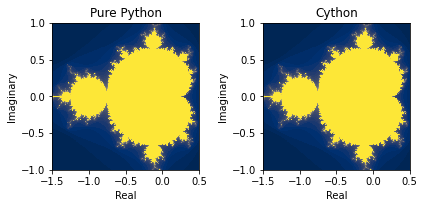

In [8]:
from matplotlib import pyplot as plt

plt.set_cmap("cividis")  # use a CVD-friendly palette

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data_python, interpolation="none", extent=[xmin, xmax, ymin, ymax])
axarr[0].set_title("Pure Python")
axarr[0].set_ylabel("Imaginary")
axarr[0].set_xlabel("Real")
axarr[1].imshow(data_cython, interpolation="none", extent=[xmin, xmax, ymin, ymax])
axarr[1].set_title("Cython")
axarr[1].set_ylabel("Imaginary")
axarr[1].set_xlabel("Real")
f.tight_layout()

In [9]:
%%timeit
[[mandel(x + 1j * y) for x in xs] for y in ys]  # pure python

410 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
[[mandel_cython(x + 1j * y) for x in xs] for y in ys]  # cython

230 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We have improved the performance of a factor of 1.5 by just using the Cython compiler, **without changing the code**!

## 9.3.2 Cython with C Types

But we can do better by telling Cython what C data types we would use in the code. Note we're not actually writing C, we're writing Python with C types.

### The --annotate Option

If we pass the `--annotate`/`-a` option to `%%cython` then it will output information about the line-by-line cost of running your function. You can use this to target the most costly operations first or to estimate how much more optimising there is to do.

In [11]:
%%cython --annotate

def mandel_cython(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter

### Typing Variables

In [12]:
%%cython

def mandel_cython_var_typed(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    cdef double complex value # typed variable
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel_cython_var_typed(0) == 50
assert mandel_cython_var_typed(3) == 1
assert mandel_cython_var_typed(0.5) == 5

In [13]:
%%timeit
[[mandel_cython_var_typed(x + 1j * y) for x in xs] for y in ys]

133 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Typing Function Parameters and Return Values

In [14]:
%%cython

cpdef int mandel_cython_func_typed(double complex constant, int max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    cdef double complex value # typed variable
    value = 0

    cdef int counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel_cython_func_typed(0) == 50
assert mandel_cython_func_typed(3) == 1
assert mandel_cython_func_typed(0.5) == 5

In [15]:
%%timeit
[[mandel_cython_func_typed(x + 1j * y) for x in xs] for y in ys]

24.3 ms ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Cython with numpy ndarray

You can use NumPy from Cython exactly the same as in regular Python, but by doing so you are losing potentially high speedups because Cython has support for fast access to NumPy arrays. 

In [16]:
import numpy as np

cs_listcomp = [[(x + 1j * y) for x in xs] for y in ys]
cs = np.asarray(cs_listcomp)

In [17]:
%%cython

import numpy as np
cimport numpy as np 

cpdef int mandel_cython_numpy(np.ndarray[double complex, ndim=2] constants, int max_iterations=50): 
    cdef np.ndarray[long,ndim=2] diverged_at_count
    cdef np.ndarray[double complex, ndim=2] value
    cdef int counter

    diverged_at_count = np.ones((constants.shape[0], constants.shape[1]), dtype=int)*max_iterations
    value = np.zeros((constants.shape[0], constants.shape[1]), dtype=complex)
    counter = 0
    while counter < max_iterations:
        value = value*value + constants
        diverging = abs(value) > 2
        
        # Any positions which are:
        # - diverging
        # - haven't diverged before
        # are diverging for the first time
        first_diverged_this_time = np.logical_and(
            diverging,
            diverged_at_count == max_iterations
        )
        
        # Update diverged_at_count for all positions which first diverged at this step
        diverged_at_count[first_diverged_this_time] = counter
        # Reset any divergent values to exactly 2
        value[diverging] = 2
        counter = counter + 1

    return diverged_at_count

assert mandel_cython_numpy(np.asarray([[0 + 1j*0]])) == np.asarray([[50]])
assert mandel_cython_numpy(np.asarray([[4 + 1j*0]])) == np.asarray([[0]])

Note the double import of numpy:

- the standard numpy module
- the Cython-enabled version of numpy that ensures fast indexing of and other operations on arrays.

**Both import statements are necessary** in code that uses numpy arrays. The new thing in the code above is declaration of arrays by np.ndarray.

In [18]:
%%timeit
mandel_cython_numpy(cs)

51.3 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
